Average Accuracy: 0.8734627557629995
Average AUC: 0.9410818228961961
训练集项目数量: 3192
测试集项目数量: 799
               precision    recall  f1-score   support

(_sex female)       0.85      0.85      0.85       312
  (_sex male)       0.91      0.90      0.90       487

     accuracy                           0.88       799
    macro avg       0.88      0.88      0.88       799
 weighted avg       0.88      0.88      0.88       799



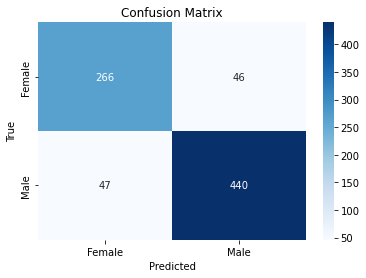

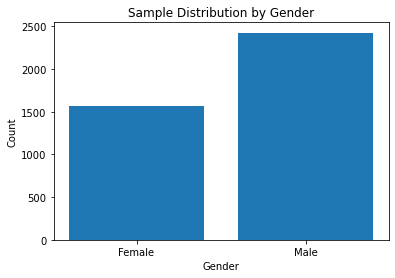

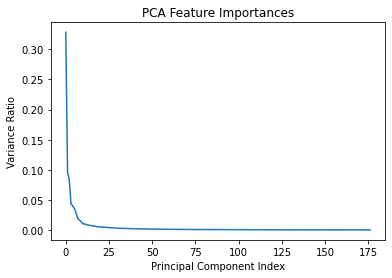

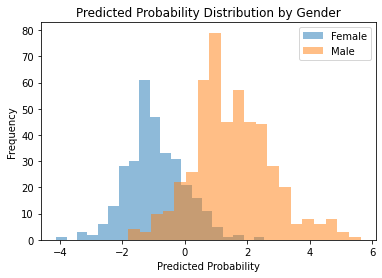

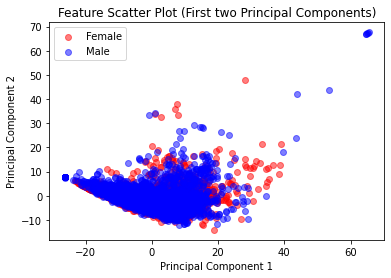

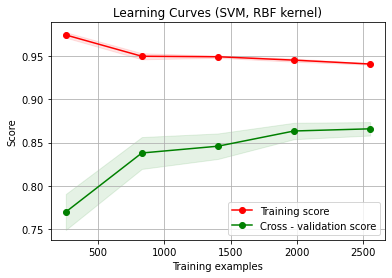

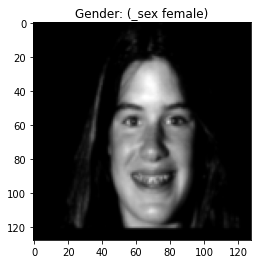

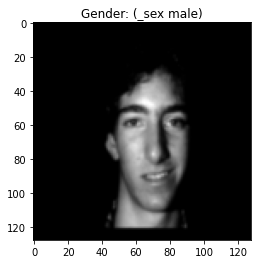

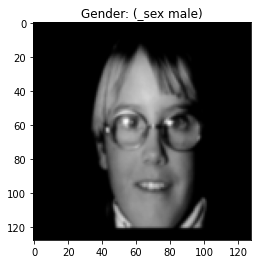

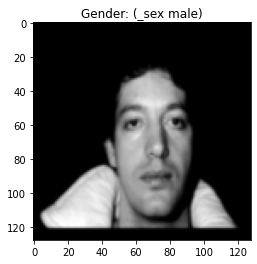

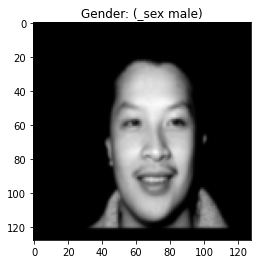

In [1]:
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats
import seaborn as sns


# 定义图像文件夹路径，用于后续读取人脸图像数据
images_folder_path = r'D:\桌面\初高衔接\人脸图像识别\face\rawdata\rawdata'
# 定义标签文件路径，该文件包含了图像对应的性别标签信息
labels_path = r'D:\桌面\初高衔接\人脸图像识别\face\rawdata\clean_sex_label.txt'

# 用于存储读取到的图像数据，每个元素为一个二维的图像矩阵（128 * 128）
image_data = []
# 用于存储与图像对应的性别标签数据，与image_data中的图像一一对应
labels_data = []

# 读取标签文件，创建一个字典，通过图像ID来映射对应的性别标签信息
labels_dict = {}
with open(labels_path, 'r') as file:
    for line in file:
        # 跳过包含(_missing descriptor)的无效行
        if "(_missing descriptor)" not in line:
            parts = line.strip().split()
            image_id = parts[0]
            label_info = " ".join(parts[1:])
            labels_dict[image_id] = label_info

# 遍历图像文件夹中的所有文件，读取符合要求的图像数据及其对应的标签
for image_filename in os.listdir(images_folder_path):
    image_id = os.path.splitext(image_filename)[0]  # 获取文件名作为图像ID
    if image_id in labels_dict:
        image_path = os.path.join(images_folder_path, image_filename)

        # 获取文件大小，简单验证文件大小是否符合预期的128 * 128图像大小
        file_size = os.path.getsize(image_path)
        if file_size == 128 * 128:
            # 以二进制读取模式打开图像文件，将图像数据读取为一维的uint8类型数组，并重塑为128 * 128的二维数组
            with open(image_path, 'rb') as f:
                image = np.fromfile(f, dtype=np.uint8).reshape(128, 128)
            image_data.append(image)

            # 根据图像ID从字典中获取对应的性别标签，并添加到标签数据列表中
            label = labels_dict[image_id]
            labels_data.append(label)

# 将图像数据列表转换为numpy数组，方便后续的数值计算和模型处理
X = np.array(image_data)
# 将标签数据列表转换为numpy数组，同样便于后续操作
y = np.array(labels_data)

# 对图像数据进行归一化处理，将像素值范围从0 - 255转换到0 - 1之间，有助于模型训练
X = X.astype('float32') / 255.0

# 特征提取部分，使用主成分分析（PCA）对图像数据进行降维处理
n_samples, height, width = X.shape
# 将二维的图像数据（n_samples个128 * 128的矩阵）展平为二维数组（n_samples行，128 * 128列），方便PCA处理
X_flattened = X.reshape((n_samples, height * width))
# 创建PCA对象，设置保留的主成分数量，使得能够解释95%的方差，以此降低数据维度同时保留主要特征信息
pca = PCA(n_components=0.95)
# 使用展平后的图像数据拟合PCA模型，找到数据中的主成分方向等信息
pca.fit(X_flattened)
# 应用PCA模型，将原始的高维图像数据转换为降维后的低维表示
X_pca = pca.transform(X_flattened)

# 使用网格搜索调整SVM参数
parameters = {'C': [0.1, 0.5, 1, 5, 10], 'gamma': [0.001, 0.01, 0.1, 1, 10]}
svm = SVC(kernel='rbf')
clf = GridSearchCV(svm, parameters, cv=5)
clf.fit(X_pca, y)
best_gamma = clf.best_params_['gamma']
best_C = clf.best_params_['C']


# 分类器性能评价部分，采用K折交叉验证来全面评估模型性能
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
auc_scores = []
for train_index, test_index in kf.split(X_pca):
    # 根据交叉验证划分的索引，获取训练集和测试集的特征数据（经过PCA降维后的）
    X_train_fold, X_test_fold = X_pca[train_index], X_pca[test_index]
    # 根据交叉验证划分的索引，获取训练集和测试集的标签数据
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # 创建支持向量机（SVM）分类器实例，选用径向基函数（RBF）核，并设置惩罚参数C和gamma为找到的最佳值
    svm = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
    # 使用训练集数据对SVM模型进行训练，让模型学习图像特征与性别标签之间的关系
    svm.fit(X_train_fold, y_train_fold)
    # 使用训练好的SVM模型对测试集数据进行预测，得到预测的性别标签
    y_pred_fold = svm.predict(X_test_fold)

    # 计算本次预测的准确率，并添加到准确率列表中
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    accuracy_scores.append(accuracy)
    try:
        # 计算本次预测的AUC值（衡量分类器在不同分类阈值下的性能表现），并添加到AUC值列表中
        auc = roc_auc_score(y_test_fold, svm.decision_function(X_test_fold))
        auc_scores.append(auc)
    except:
        # 处理可能出现的AUC计算问题，例如当测试集数据中全为同一类别的样本时会出现异常情况
        continue

# 输出K折交叉验证得到的平均准确率，反映模型在整体数据上的分类准确程度
print("Average Accuracy:", np.mean(accuracy_scores))
# 输出K折交叉验证得到的平均AUC值，综合评估模型在不同分类阈值下的性能表现
print("Average AUC:", np.mean(auc_scores))

# 最终划分训练集和测试集进行一次完整的训练和评估
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
# 新增打印训练集和测试集项目数量的代码
print("训练集项目数量:", len(X_train))
print("测试集项目数量:", len(X_test))
# 创建SVM分类器实例，选用径向基函数（RBF）核，并设置惩罚参数C和gamma为找到的最佳值
svm = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
svm.fit(X_train, y_train)
# 使用训练好的SVM模型对测试集数据进行预测，得到最终的预测性别标签
y_pred = svm.predict(X_test)
# 输出详细的分类报告，包括精确率、召回率、F1值等指标，全面分析模型在测试集上的分类性能表现
print(classification_report(y_test, y_pred))

# 计算混淆矩阵
cm_matrix = confusion_matrix(y_test, svm.predict(X_test))
# 将混淆矩阵可视化，使用热力图展示，更直观地看出分类情况
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 绘制不同类别样本的分布情况
female_count = np.sum(np.array(labels_data) == '(_sex female)')
male_count = np.sum(np.array(labels_data) == '(_sex male)')
labels = ['Female', 'Male']
counts = [female_count, male_count]
plt.bar(labels, counts)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Sample Distribution by Gender')
plt.show()

# 绘制特征重要性，这里以PCA后的特征为例，简单展示每个主成分的方差贡献
pca_variances = pca.explained_variance_ratio_
plt.plot(range(len(pca_variances)), pca_variances)
plt.xlabel('Principal Component Index')
plt.ylabel('Variance Ratio')
plt.title('PCA Feature Importances')
plt.show()

# 绘制预测概率分布
if hasattr(svm, 'decision_function'):
    y_pred_proba = svm.decision_function(X_test)
elif hasattr(svm, 'predict_proba'):
    y_pred_proba = svm.predict_proba(X_test)[:, 1]
else:
    raise ValueError("SVM model does not have decision_function or predict_proba method.")

plt.hist(y_pred_proba[y_test == '(_sex female)'], bins=20, alpha=0.5, label='Female')
plt.hist(y_pred_proba[y_test == '(_sex male)'], bins=20, alpha=0.5, label='Male')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Predicted Probability Distribution by Gender')
plt.legend()
plt.show()

# 绘制特征的二维散点图（使用前两个主成分）
plt.scatter(X_pca[y == '(_sex female)', 0], X_pca[y == '(_sex female)', 1], c='r', label='Female', alpha=0.5)
plt.scatter(X_pca[y == '(_sex male)', 0], X_pca[y == '(_sex male)', 1], c='b', label='Male', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Feature Scatter Plot (First two Principal Components)')
plt.legend()
plt.show()

# 绘制学习曲线
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross - validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves (SVM, RBF kernel)"
cv = 5
estimator = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
plot_learning_curve(estimator, title, X_train, y_train, cv=cv)
plt.show()

# 随机选择并展示一些原始图像样本
num_samples_to_show = 5
random_indices = np.random.choice(len(X), num_samples_to_show, replace=False)
for index in random_indices:
    image = X[index]
    label = y[index]
    plt.imshow(image, cmap='gray')
    plt.title(f'Gender: {label}')
    plt.show()